# HELIOS Seq Analysis of Hek cells
## What has been done so far...
Several DataProcessing steps were done till here with other software on the computational cluster
* fastq were trimmed and demultiplexed with cutadapt
* quality checked and further trimmed with trimmomatic
* reads were aligned with hisat2 to reference genome and reference spikeRNA, done for merged reads and not merged/paired reads separately
* count tables produced with featureCounts
* a custom python script extracts output from hisat2 for the spike RNAs and puts them in a table for further processing
* in 01_Analysis data was
  * annotated
  * filtered
  * normalized
  * spike content was compared
* in 02_Analysis calculation were made:
  * enrichmentfactors
  * logfoldchanges
  * statistical tests



In [65]:
# import required modules
import os
import pandas as pd
import numpy as np
import anndata as ad
import gseapy as gp
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import seaborn as sns
from scipy.stats import ranksums
from scipy.stats import ttest_ind
from confidence_ellypse import confidence_ellipse

colors = sns.color_palette("tab10")
colors[8] = "gold"

from sklearn.preprocessing import StandardScaler

#pd.set_option('display.max_columns', None)

In [2]:
adata = ad.read_h5ad("data/anndata.h5ad")
adata

AnnData object with n_obs × n_vars = 24 × 5588
    obs: 'encoding', 'pos_neg', 'treatment', 'gene_counts', 'biotinRna', 'biotin_scalingF'
    var: 'Chr', 'Start', 'End', 'Strand', 'Length', 'Ensemble_ID', 'ensembl_gene_id', 'external_gene_name', 'description', 'gene_biotype', 'entrezgene_id', 'start_position', 'end_position', 'chromosome_name', 'total_values', 'highest_sample', 'NADcap_Control', 'NADcap_FK', 'NADcap_NRH', 'NADcap_Rot', 'sums'
    uns: 'L2FC_spikes', 'enrichmentfactors_spikes', 'normalized_spike_counts', 'original_spike_table', 'spike_correlation', 'spike_counts'
    varm: 'L2FC', 'L2FC_mean_statTests', 'enrichmentfactors'
    layers: 'biotin_scaled'

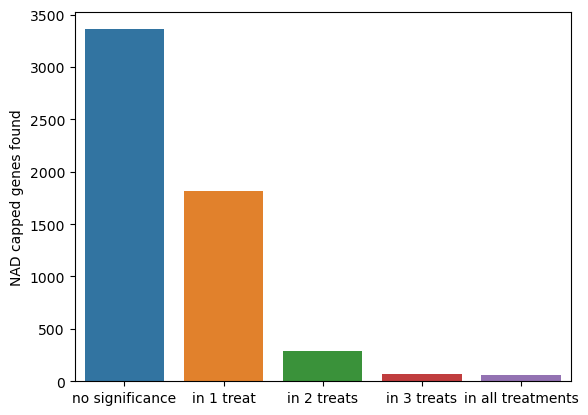

In [143]:
# adding NAD capping information to .var
fig, ax = plt.subplots()
adata.var["sums"] = adata.var[adata.var.columns[adata.var.columns.str.match("NADcap_")]].sum(1)
sns.countplot(data = adata.var, x="sums")
ax.set(xticklabels = ["no significance", "in 1 treat", "in 2 treats", "in 3 treats", "in all treatments"], 
       xlabel = None, ylabel = "NAD capped genes found")
plt.show()

In [127]:
# top10 highest pValues in sig in all 
df = sig_in_all.varm["L2FC_mean_statTests"].copy()
df["pval_sum"] = df["Control_ttest_pval"] + df["FK_ttest_pval"] + df["NRH_ttest_pval"] + df["Rot_ttest_pval"]
most_sig_genes = df.sort_values("pval_sum").index[:10]
most_sig_genes

Index(['ENSG00000198712.1', 'ENSG00000210049.1', 'ENSG00000210077.1',
       'ENSG00000210191.1', 'ENSG00000210144.1', 'ENSG00000198804.2',
       'ENSG00000198888.2', 'ENSG00000288957.2', 'ENSG00000210196.2',
       'ENSG00000209082.1'],
      dtype='object')

In [128]:
adata[:, most_sig_genes].var[["external_gene_name", "description", "gene_biotype"]]

,external_gene_name,description,gene_biotype
Feature,,,
ENSG00000198712.1,MT-CO2,mitochondrially encoded cytochrome c oxidase I...,protein_coding
ENSG00000210049.1,MT-TF,mitochondrially encoded tRNA-Phe (UUU/C) [Sour...,Mt_tRNA
ENSG00000210077.1,MT-TV,mitochondrially encoded tRNA-Val (GUN) [Source...,Mt_tRNA
ENSG00000210191.1,MT-TL2,mitochondrially encoded tRNA-Leu (CUN) 2 [Sour...,Mt_tRNA
ENSG00000210144.1,MT-TY,mitochondrially encoded tRNA-Tyr (UAU/C) [Sour...,Mt_tRNA
ENSG00000198804.2,MT-CO1,mitochondrially encoded cytochrome c oxidase I...,protein_coding
ENSG00000198888.2,MT-ND1,mitochondrially encoded NADH:ubiquinone oxidor...,protein_coding
ENSG00000288957.2,NaN,novel transcript,lncRNA
ENSG00000210196.2,MT-TP,mitochondrially encoded tRNA-Pro (CCN) [Source...,Mt_tRNA


In [60]:
adata[:, adata.var["sums"] >=2 ].var.groupby("gene_biotype")["gene_biotype"].count()

gene_biotype
Mt_rRNA                             2
Mt_tRNA                            17
TEC                                 1
lncRNA                             49
misc_RNA                            1
protein_coding                    331
snRNA                               4
snoRNA                              5
transcribed_unitary_pseudogene      1
Name: gene_biotype, dtype: int64

In [89]:
gene_subset = adata[:, adata.var["sums"] >=2 ].varm["L2FC"].iloc[:,0:12].T
gene_subset

components = 10


pca = PCA(n_components = components)
pca_frame = pd.DataFrame(pca.fit_transform(gene_subset), columns = ["PC"+ str(n+1) for n in range(components)],
                        index = gene_subset.index).reset_index()
pca_frame["sample"] = pca_frame["index"].apply(lambda x: x[:-1])
pca_frame

,index,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,sample
0,Control1,-22.578110,41.456492,2.062391,-2.868488,-7.043115,-4.487615,0.696480,-0.767129,-5.090996,-1.917167,Control
1,Control2,-11.730978,5.970869,-10.643821,-2.502151,25.469575,16.670744,0.856038,-4.286543,7.178118,7.109203,Control
2,Control3,-28.353153,-10.383656,-10.982209,30.693163,-2.428558,0.641408,-4.108960,5.496997,-6.045875,-4.956705,Control
3,FK1,32.596443,5.211801,-12.633808,5.280905,-8.043681,5.125686,17.914892,6.384358,11.166732,-5.071834,FK
4,FK2,33.440381,4.167226,-3.224866,0.445409,-1.687233,-3.198728,-15.172373,8.714335,3.505624,-1.735484,FK
5,FK3,30.886185,1.543824,-0.914874,7.956979,3.722490,-7.585528,-10.221906,-17.975797,-7.329358,6.804132,FK
6,NRH1,-11.670630,-13.005348,-16.749634,-16.126496,-19.198842,6.679406,0.929421,-5.015323,-6.877719,11.633648,NRH
7,NRH2,2.752484,-9.285065,-5.201784,-13.798878,14.018710,-12.239837,9.826181,4.071706,-16.247039,-12.199217,NRH
8,NRH3,-21.486104,-9.334196,-0.229848,-11.238660,-2.069130,-9.398607,-10.682612,-4.893017,19.441621,-11.296535,NRH
9,Rot1,5.469151,-5.201282,24.801481,-2.025310,-4.992778,21.827360,-2.162013,-3.561647,-6.242507,-11.445902,Rot


array([0.2763984 , 0.12303285, 0.10018088, 0.08991204, 0.07287081,
       0.06725547, 0.06118592, 0.05766417, 0.05662238, 0.05167917])

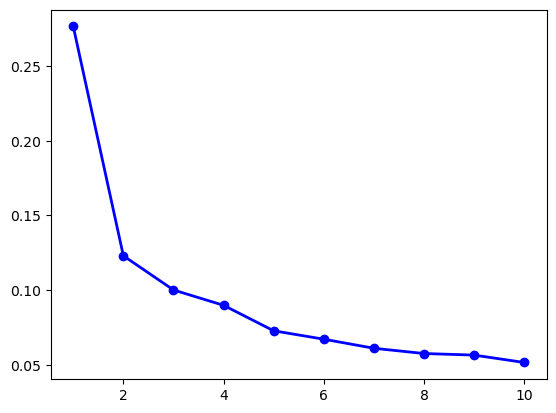

In [91]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
pca.explained_variance_ratio_

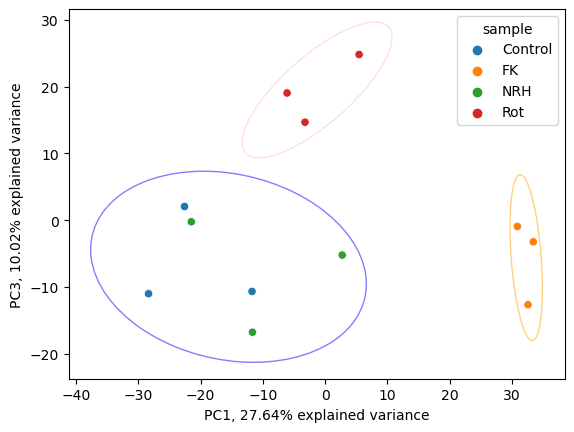

In [108]:
fig, ax = plt.subplots()
sns.scatterplot(data = pca_frame, x = "PC1", y = "PC3", hue = "sample", ax = ax)

sub_FK = pca_frame[pca_frame["sample"] == "FK"]
sub_ctrlNRH = pca_frame[np.logical_or(pca_frame["sample"] == "Control", pca_frame["sample"] == "NRH")]
sub_rot = pca_frame[pca_frame["sample"] == "Rot"]


confidence_ellipse(sub_FK["PC1"], sub_FK["PC3"], ax = ax,  n_std = 2, edgecolor = "orange", alpha = .5 )
confidence_ellipse(sub_ctrlNRH["PC1"], sub_ctrlNRH["PC3"], ax = ax, n_std = 2, edgecolor = "blue", alpha = .5 )
confidence_ellipse(sub_rot["PC1"], sub_rot["PC3"], n_std = 2,  ax = ax, edgecolor = "pink", alpha = .5 )

ax.set_ylabel("PC3, {:.2%} explained variance".format(pca.explained_variance_ratio_[2]))
ax.set_xlabel("PC1, {:.2%} explained variance".format(pca.explained_variance_ratio_[0]))
plt.show()

## KEGG pathway enrichment analysis

In [ ]:
results = {}
for condition, gene_set_list in gene_sets.items():
    # Replace 'expression_data_conditionX.txt' with your actual expression data file
    result = gp.prerank(rnk='expression_data_conditionX.txt', gene_sets=gene_set_list, outdir=condition)
    results[condition] = result

In [226]:
sig_in_all = adata[:, adata.var["sums"] >=1]
sig_in_all_list = sig_in_all.var["external_gene_name"].dropna().tolist()
sig_in_all.var.groupby("gene_biotype")["gene_biotype"].count()

gene_biotype
Mt_rRNA                                2
Mt_tRNA                               18
TEC                                    8
lncRNA                               278
misc_RNA                               2
processed_pseudogene                   1
protein_coding                      1891
rRNA_pseudogene                        2
snRNA                                  8
snoRNA                                15
transcribed_processed_pseudogene       1
transcribed_unitary_pseudogene         2
unprocessed_pseudogene                 1
Name: gene_biotype, dtype: int64

In [217]:
enrichr_result_all_sig = gp.enrichr(gene_list=sig_in_all_list ,
 gene_sets=['GO_Biological_Process_2021'],
 organism='Human',
 cutoff=0.5, verbose = True
 )
enrichr_result_all_sig.results.head()

2023-11-20 16:37:09,959 [INFO] Run: GO_Biological_Process_2021 
2023-11-20 16:37:17,573 [INFO] Done.


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,mRNA processing (GO:0006397),79/300,5.937642e-15,2.626813e-11,0,0,3.125265,102.375744,DBR1;AKAP8L;DDX42;GPATCH1;PPWD1;USP39;ELAVL2;C...
1,GO_Biological_Process_2021,"RNA splicing, via transesterification reaction...",69/251,3.190417e-14,4.939589e-11,0,0,3.305553,102.723510,DBR1;DDX42;GPATCH1;PPWD1;USP39;ELAVL2;CCAR1;PT...
2,GO_Biological_Process_2021,"mRNA splicing, via spliceosome (GO:0000398)",73/274,3.349631e-14,4.939589e-11,0,0,3.169444,98.339411,DBR1;DDX42;GPATCH1;PPWD1;USP39;ELAVL2;CCAR1;PT...
3,GO_Biological_Process_2021,gene expression (GO:0010467),85/356,2.311782e-13,2.556831e-10,0,0,2.742598,79.797499,SMG1;RPL3;NUP188;FASTKD2;RPL34;MRPL37;RPL8;PWP...
4,GO_Biological_Process_2021,protein ubiquitination (GO:0016567),107/525,1.008419e-11,7.687423e-09,0,0,2.244133,56.821567,UBE2D2;FBXO28;UBE2D3;FBXO21;PSMD8;PSMD7;RNF114...


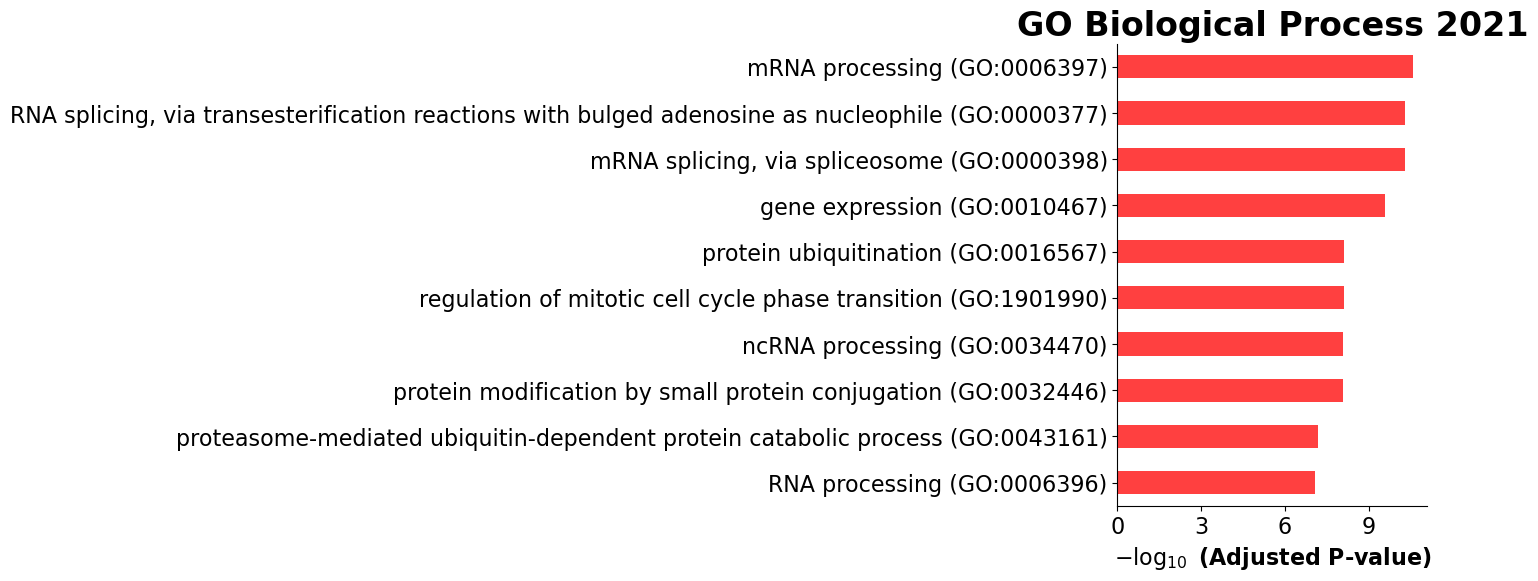

In [227]:
barplot(enrichr_result_all_sig.res2d,title='GO Biological Process 2021',color = 'r')
plt.show()